1 and 2 parameter bifurcation diagrams for vdp-thal

# Imports

In [1]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
# user-defined
import nmCoupling as nm
import response as rp

import vdp_thal

import importlib
import lib

from lib.util import (get_phase, freq_est,follow_phase_diffs,follow_phase_diffs_del,
                        follow_phase_diffs_u,follow_phase_diffs_u_del,
get_smallest_eps,get_largest_eps,numerical_jac,get_es_min,get_es_max)

from lib.plot_util import (add_diagram_1d_scatter, quick_plot_combined, 
                            draw_quick_plot_f, add_diagram_1d_del_scatter)

import lib.rhs

importlib.reload(sys.modules['lib.util'])
importlib.reload(sys.modules['lib.rhs'])
from lib.util import (get_phase, freq_est)
#from lib.rhs import (_redu)
from lib.rhs import _redu_c2, _full, _full_mono_rhs

_redu = _redu_c2

from importlib import reload
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import os
from matplotlib.patches import Circle

from scipy.optimize import root,bisect
from copy import deepcopy

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

nmc = nm.nmCoupling
rsp = rp.Response

# Dicts

In [2]:
kw_sim = {'rtol':1e-7,'atol':1e-7,'method':'LSODA'}

In [3]:
pd_thal = {'gL':0.05,'gna':3,'gk':5,
           'gt':5,'eL':-70,'ena':50,
           'ek':-90,'et':0,'esyn':-100,
           'c':1,'alpha':3,'beta':2,
           'sigmat':0.8,'vt':-20,'del':0,
           'ib':8.2,'om':1,'om_fix':1}

pd_vdp = {'mu':.04,'sigmat':0.1,'vt':1,
          'alpha':3,'beta':2,'esyn':-2,
          'del':0,'om':1,'om_fix':1}

In [4]:
# default period must be 2*np.pi
kws_thal = {'var_names':['v','h','r','w'],
            'pardict':pd_thal,
            'rhs':vdp_thal.rhs_thal,
            'coupling':vdp_thal.coupling_thal,
            'init':np.array([-.64,0.71,0.25,0,6]),
            'TN':10000,
            'trunc_order':1,
            'z_forward':False,
            'i_forward':False,
            'i_bad_dx':[False,True,False,False,False,False],
            'max_iter':20,
            'rtol':1e-12,
            'atol':1e-12,
            'rel_tol':1e-9,
            'save_fig':True,
            'lc_prominence':.05}

kws_vdp = {'var_names':['v','h','w'],
               'pardict':pd_vdp,
               'rhs':vdp_thal.rhs_vdp,
               'coupling':vdp_thal.coupling_vdp,
               'init':np.array([.32,0.128,0.54,20]),
               'TN':10000,
               'trunc_order':1,
               'z_forward':False,
               'i_forward':False,
               'i_bad_dx':[False,True,False,False,False,False],
               'max_iter':20,
               'rtol':1e-12,
               'atol':1e-12,
               'rel_tol':1e-9,
               'save_fig':True,
               'lc_prominence':.05}

In [5]:
het_coeffs = [1,20]

# Defs

In [6]:
mname1 = 'vdp_thal32_b={}'
mname2 = 'vdp_thal32_b2={}'

mname_list = ['vdp_thal11_b'+str(i)+'={}' for i in range(5)]

In [7]:
# es_min,phi0 = get_es_min(data_bs_list,data_bu_list)
def get_monodromy_full(es_min,phi0,a,b,mname='',tol=1e-6,recompute=False):
    """
    es_min: minimum epsilon to use
    a: nmCoupling object
    b: het. parameter.
    mnamei are the model names to save the monodromy matrix and related calculations
    """    

    kw_b = {'a':a,'b':b,'recompute':recompute,'bifdir':'bif1d_vdp_thal/','_full_rhs':_full}
    print('es_min,phi0',es_min,phi0)
    # the _u function has the ability to save and load Y values
    _,Y = follow_phase_diffs(**dict(phi0=phi0,eps_init=es_min,eps_final=es_min-.01,deps=-1),max_time=10000,tol=tol,return_point=True,**kw_b)

    print('Y',Y)
    # define parameters for finding monodromy of full system
    pd_vdp_thal = {**a.system1.pardict,**a.system2.pardict}
    pd_vdp_thal['b']=b
    pd_vdp_thal['a']=a
    
    pd_vdp_thal['eps']=es_min
    # print(pd1['del0'])
    
    # default period must be 2*np.pi
    kws_vdp_thal = {'var_names':['v0','h0','r0','w0','v1','h1','w1'],
                    'pardict':pd_vdp_thal,
                    'rhs':_full_mono_rhs,
                    'coupling':lambda x: 0*x,
                    'init':Y, # from above
                    'use_init':True, # use init for direct LC calculation
                    'TN':10000,
                    'rtol_lc':1e-10,
                    'atol_lc':1e-10,
                    'trunc_order':0,
                    'z_forward':False,
                    'i_forward':False,
                    'i_bad_dx':[False,True,False,False,False,False],
                    'save_fig':False,
                    'max_iter':50,
                    'max_time_lc':5000,
                    'tol_root_lc':1e-8,
                    'halt_after_mono':True}

    m1 = rsp(idx='',model_name=mname,**kws_vdp_thal)

    return m1

In [8]:
def compute_sol_all(a,eps,phi0,b,T=2000,dt=.01):
    """
    only for use in jupyter
    """
    t = np.arange(0,T,dt)
    args = {'args':(a,eps,b), 't_eval':t,**kw_sim}

    y0a = a.system1.lc['dat'][int((phi0/(2*np.pi)) * a.system1.TN),:]
    y0b = a.system2.lc['dat'][int((0/(2*np.pi)) * a.system2.TN),:]
    y0 = np.concatenate([y0a,y0b]).flatten()
    #a.system1.pardict['del0'] = b

    solf = solve_ivp(_full,[0,t[-1]], y0, **args)

    args['args'] = (a,eps,b,1)
    solr_o1 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    args['args'] = (a,eps,b,2)
    solr_o2 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    #args['args'] = (a,eps,b,3)
    #solr_o3 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    #args['args'] = (a,eps,b,4)
    #solr_o4 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)

    return solf, solr_o1, solr_o2#, solr_o3, solr_o4


def load_sol_all(a,eps,phi0,b,T,dt=.01,path_loc='sols_temp/',recompute=False,
                 return_full=False,**kwargs):
    if (not os.path.exists(path_loc)):
        os.makedirs(path_loc)
    
    fname_f = path_loc+'sol_f_thal2_nm={}{}_eps={}_b={}_T={}_phi0={}.dat'.format(a._n[1],a._m[1],eps,b,T,phi0)
    fname_r = path_loc+'sol_r_thal2_nm={}{}_eps={}_b={}_T={}_phi0={}.dat'.format(a._n[1],a._m[1],eps,b,T,phi0)
    file_dne = not(os.path.isfile(fname_f))
    file_dne += not(os.path.isfile(fname_r))

    if file_dne or recompute:
        solf, solr_o1, solr_o2 = compute_sol_all(a,eps,phi0,b,T=T,dt=dt)

        # phase of full model
        ta, pha = get_phase(solf.t,solf.y.T[:,:4], skipn=200,system1=a.system1)
        tb, phb = get_phase(solf.t,solf.y.T[:,4:], skipn=200,system1=a.system2)

        dat1 = np.zeros([len(ta),2])
        dat1[:,0] = ta
        dat1[:,1] = np.mod(pha - a.om*phb,2*np.pi)

        dat2 = np.zeros([len(solr_o1.t),5])
        dat2[:,0] = solr_o1.t
        dat2[:,1] = solr_o1.y[0]
        dat2[:,2] = solr_o2.y[0]
        #dat2[:,3] = solr_o3.y[0]
        #dat2[:,4] = solr_o4.y[0]

        np.savetxt(fname_f,dat1)
        np.savetxt(fname_r,dat2)

    else:
        dat1 = np.loadtxt(fname_f)
        dat2 = np.loadtxt(fname_r)
    return dat1, dat2

# Initialize

In [9]:
system1 = rsp(idx=0,model_name='vdp_thal0',**kws_thal)
system2 = rsp(idx=1,model_name='vdp_thal1',**kws_vdp)

mkdir ./data/vdp_thal0/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0084015231173136
self.T 6.283185307179586
LC0 ini[-0.10425117  0.22993228  0.09898925  0.40570217]
LC0 fin[-0.10425117  0.22993228  0.09898925  0.40570217]
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.024653498269982924
* Loading g symbolic...
* Computing g...
g0 ini[0. 0. 0. 0.]
g0 fin[0. 0. 0. 0.]
g1 ini[ 0.00253413 -0.64088722 -0.22868543  0.73277563]
g1 fin[ 0.00253409 -0.64088719 -0.22868543  0.73277558]
* Loading heterogeneous terms...
* Computing z...
z0 ini[-0.87597607 -1.17574397  3.28529655 -0.        ]
z0 fin[-0.87597607 -1.17574397  3.28529652 -0.        ]
z1 ini[-1.70646067 -0.61636896  0.14424813  0.        ]
z1 fin[-1.70646067 -0.61636896  0.14424813  0.        ]
* Computing i...
i0 ini[-0.23544813  0.01818327 -4.42638639  0.        ]
i0 fin[-0.23544811  0.01818329 -4.4263864   0.        ]
i1 ini[-9.66309554e-02  7.45216330e-01 -6.49855309e-02  8.64027668e-21]

# Initialize Coupling 3:2

In [10]:
# parameters to be fixed for 1 par diagrams
nm_tup = (3,2)

In [11]:
a32 = nm.nmCoupling(system1,system2,
                    #recompute_list=['k_gwt1','p_gwt1'],
                    #recompute_list=['p_data_gwt0','p_data_gwt1','h_data_gwt0','h_data_gwt1'],
                    #recompute_list=recompute_list,
                    _n=('om0',nm_tup[0]),_m=('om1',nm_tup[1]),
                    het_coeffs=het_coeffs,
                    NH=1024)

Initializing 32 Coupling...
pfactor 29
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
* Loading H symbolic...
* Loading H symbolic...
* Loading H vdp_thal0, order=0...
* Loading H vdp_thal1, order=0...
* Loading H vdp_thal0, order=1...
* Loading H vdp_thal1, order=1...


In [12]:
# define aliases as a template
a = a32

nm_val = str(nm_tup[0])+str(nm_tup[1])

In [13]:
etup = (0,.11,100)
dtup = (-.115,-.105)

## Phase line

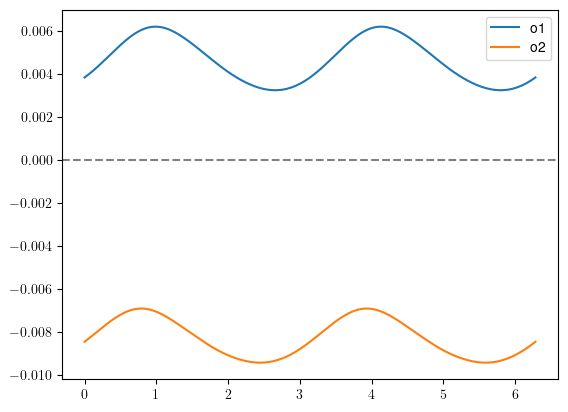

In [14]:
a = a32
e = .1
b = -.113
x_temp2 = np.linspace(0,2*np.pi,200)

rhs1 = _redu(0,x_temp2,a,e,b,miter=1)
rhs2 = _redu(0,x_temp2,a,e,b)

fig,axs = plt.subplots()
axs.plot(x_temp2,rhs1,label='o1')
axs.plot(x_temp2,rhs2,label='o2')
axs.axhline(0,0,2*np.pi,ls='--',color='gray')
axs.legend()

## Plot 1par eps

<Axes: >

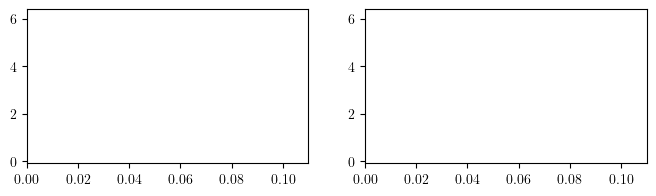

In [15]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=-.1,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

<Axes: >

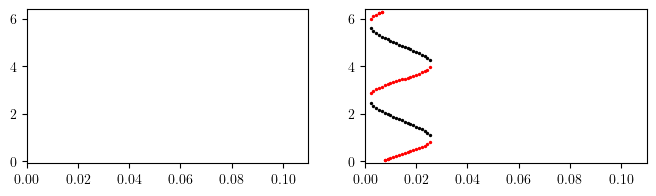

In [16]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=-.108,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

In [17]:
# fig,axs = plt.subplots(1,2,figsize=(8,2))
# kw_diagram = dict(a=a,b=-.109,eps_tup=etup,rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

In [18]:
# fig,axs = plt.subplots(1,2,figsize=(8,2))
# kw_diagram = dict(a=a,b=-.11,eps_tup=etup,rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

<Axes: >

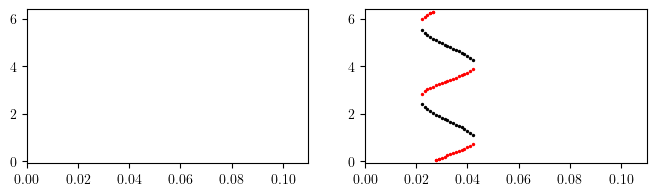

In [19]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=-.112,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

## Plot 1par del

In [20]:
# fig,axs = plt.subplots(1,2,figsize=(6,2))
# kw_diagram = dict(a=a,eps=e1,del_tup=dtup,rhs=_redu_c2)
# add_diagram_1d_del_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_del_scatter(axs[1],miter=2,**kw_diagram)

### Sim

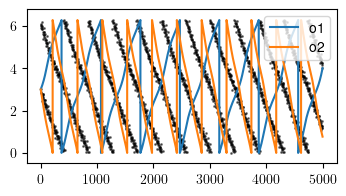

In [21]:
a=a32;T=5000;b=-.112;e=.08;phi0 = 3
dat1,dat2=load_sol_all(a=a,eps=e,phi0=phi0,b=b,T=T,recompute=False)
t1=dat1[:,0];y=dat1[:,1]
t2=dat2[:,0];so1=dat2[:,1];so2=dat2[:,2]

fig,axs = plt.subplots(figsize=(4,2))

axs.scatter(t1,y,s=1,alpha=.5,color='black')

axs.plot(t2,np.mod(so1,2*np.pi),label='o1')
axs.plot(t2,np.mod(so2,2*np.pi),label='o2')

axs.set_ylim(-.5,2*np.pi+.5)
axs.legend()

## EPS VARY

In [22]:
kw_b = {'a':a,'b':0,'recompute':False,'bifdir':'bif1d_vdp_thal/','_full_rhs':_full}
fname_bs = kw_b['bifdir']+'hyper_gwt_'+nm_val+'_b={}_s.txt'
fname_bu = kw_b['bifdir']+'hyper_gwt_'+nm_val+'_b={}_u.txt'

In [23]:
b_vals_full = []
e_vals_full = [] # save min eps values for all diagrams
e_hi_full = [] # save max eps values for all diagrams

## monodromy calculations
e_vals_mono_min = [] # save eps values at min monodromy
eigenvalues_min_all = []
b_min_all = []

e_vals_mono_max = [] # save eps values at max monodromy
eigenvalues_max_all = []
b_max_all = []

### b=-.108

#### Branches eps stable

<Axes: >

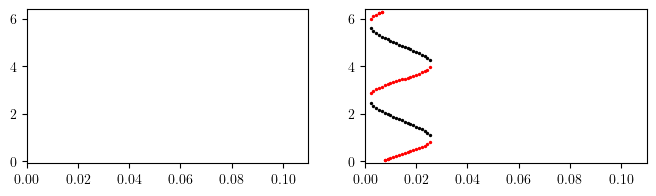

In [24]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=-.108,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

In [25]:
b=-.108
kw_b['recompute'] = False
kw_b['b'] = b

In [26]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=5,eps_init=0.018,eps_final=0.001,deps=-.001,max_iter=50),
            dict(phi0=4.6,eps_init=0.017,eps_final=0.1,deps=.001,max_iter=50),
            #dict(phi0=3,eps_init=0.049,eps_final=0.1,deps=.001)
           ]

In [27]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 5
phi init 4.6


In [28]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Sim

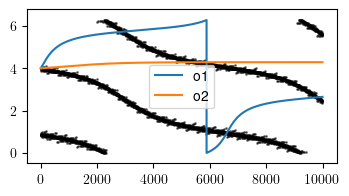

In [29]:
a=a32;T=10000;b=-.108;e=.025;phi0 = 4
dat1,dat2=load_sol_all(a=a,eps=e,phi0=phi0,b=b,T=T,recompute=False)
t1=dat1[:,0];y=dat1[:,1]
t2=dat2[:,0];so1=dat2[:,1];so2=dat2[:,2]

fig,axs = plt.subplots(figsize=(4,2))

axs.scatter(t1,y,s=1,alpha=.5,color='black')

axs.plot(t2,np.mod(so1,2*np.pi),label='o1')
axs.plot(t2,np.mod(so2,2*np.pi),label='o2')

axs.set_ylim(-.5,2*np.pi+.5)
axs.legend()

#### Branches eps unstable

In [30]:
kw_b['recompute'] = False
kw_b['b'] = b

In [31]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.017,eps_final=0.0,deps=-1),return_point=True,**kw_b)
# dat,Yinit = follow_phase_diffs_u(**dict(phi0=1.2,eps_init=0.019,eps_final=0.018,deps=-.01),return_point=True,**kw_b)

phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.108_ei=0.017_ef=0.0_de=-1.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.108_ei=0.017_ef=0.0_de=-1.txt


In [32]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=3.5,eps_init=0.017,eps_final=0.001,deps=-.001),
            dict(phi0=3.5,eps_init=0.016,eps_final=0.1,deps=.001),
            #dict(phi0=3,eps_init=0.049,eps_final=0.1,deps=.001)
           ]

In [33]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.108_ei=0.017_ef=0.001_de=-0.001.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.108_ei=0.017_ef=0.001_de=-0.001.txt
phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.108_ei=0.016_ef=0.1_de=0.001.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.108_ei=0.016_ef=0.1_de=0.001.txt


In [34]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

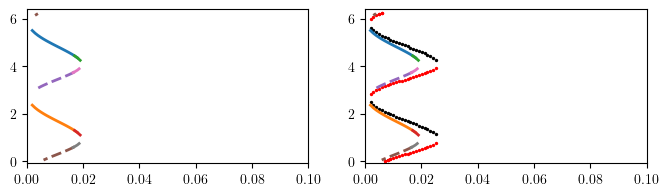

In [35]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=(0,.1,100),rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys max

In [36]:
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)
print(es_max,phi0)

0.019000000000000003 [0.019      2.09434177 2.09434177 4.24252512 1.09763237]


In [37]:
kw_b = {'a':a,'b':b,'recompute':False,'bifdir':'bif1d_vdp_thal/','_full_rhs':_full}

In [38]:
dat = follow_phase_diffs(**dict(phi0=3.9,eps_init=0.019-.0001,eps_final=0,deps=-1,max_iter=50),**kw_b)

phi init 3.9


In [39]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-.0001-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.018900000000000004 1.097632371981586
phi init 1.097632371981586
Y [-0.10550165  0.22253475  0.09848951  0.41328186  1.43920351 -1.37835562  0.43953886  6.28318252]
mkdir ./data/vdp_thal11_b0=-0.108/
* Loading LC data...
self.T 6.283185307179586 omfix 0.9999995588980982
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.00024378021481807923
es_min,phi0 0.018400000000000003 1.097632371981586
phi init 1.097632371981586
Y [-0.10547322  0.2394994   0.09857048  0.39384915  1.36813161 -1.44859066  0.39587033  6.2831777 ]
mkdir ./data/vdp_thal11_b1=-0.108/
* Loading LC data...
self.T 6.283185307179586 omfix 0.9999987890505763
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.000294177033955159
es_min,phi0 0.017900000000000003 1.097632371981586
phi init 1.097632371981586
Y [-0.10536159  0.23866699  0.09857969  0.39484347  1.32285493 -1.48987561  0.36416102  6.2831737 ]
mkdi

In [40]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-.109

#### Branches eps stable

In [41]:
b=-.109
kw_b['recompute'] = False
kw_b['b'] = b

In [42]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0.001,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [
            #dict(phi0=4.7,eps_init=0.022,eps_final=0.001,deps=-.001,max_iter=50),
            #dict(phi0=1.7,eps_init=0.014,eps_final=0.001,deps=-.001,max_iter=50),
            #dict(phi0=4.83,eps_init=0.011,eps_final=0.001,deps=-.001,max_iter=50),
            dict(phi0=1.76,eps_init=0.01,eps_final=0.001,deps=-.001,max_iter=100),
            dict(phi0=1.76,eps_init=0.009,eps_final=0.101,deps=.001,max_iter=100),
           ]

In [43]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 1.76
phi init 1.76


In [44]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [45]:
kw_b['recompute'] = False
kw_b['b'] = b

In [46]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.008,eps_final=0,deps=-1),return_point=True,**kw_b)
# dat,Yinit = follow_phase_diffs_u(**dict(phi0=1.2,eps_init=0.019,eps_final=0.018,deps=-.01),return_point=True,**kw_b)

phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.109_ei=0.008_ef=0_de=-1.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.109_ei=0.008_ef=0_de=-1.txt


In [47]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [
            dict(phi0=3,eps_init=0.0079,eps_final=0.0,deps=-.001),
            dict(phi0=3,eps_init=0.0078,eps_final=0.1,deps=.001),
            
            #dict(phi0=3,eps_init=0.049,eps_final=0.1,deps=.001)
           ]

In [48]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 3
phase_diffs_u_init=3_nm=32_b=-0.109_ei=0.0079_ef=0.0_de=-0.001.txt
phase_diffs_u_pt_init=3_nm=32_b=-0.109_ei=0.0079_ef=0.0_de=-0.001.txt
phi init 3
phase_diffs_u_init=3_nm=32_b=-0.109_ei=0.0078_ef=0.1_de=0.001.txt
phase_diffs_u_pt_init=3_nm=32_b=-0.109_ei=0.0078_ef=0.1_de=0.001.txt


In [49]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

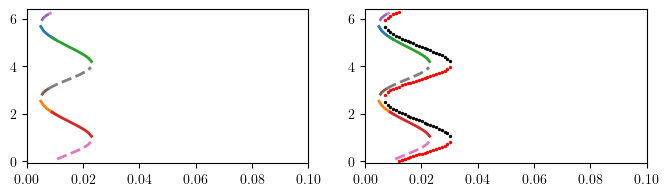

In [50]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=(0,.1,100),rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [51]:
# # get min eps
# es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


# eigenvalues_temp = []
# es_min_temp = []
# for i in range(5):
#     ee = es_min+.0001+0.0005*i
#     m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
#     eigenvalues_temp.append(m1.eigenvalues)
#     es_min_temp.append(ee)

# eigenvalues_min_all.append(eigenvalues_temp)
# e_vals_mono_min.append(es_min_temp)
# #m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# # m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
# #

# #print(m1.eigenvalues)
# #print(m1b.eigenvalues)

In [52]:
# fig,axs = plt.subplots(figsize=(3,3))
# axs.scatter(m1.eigenvalues.real,m1.eigenvalues.imag)
# axs.scatter(m1b.eigenvalues.real,m1b.eigenvalues.imag,color='red')
# circ = Circle((0, 0), radius=1, edgecolor='k', facecolor='None'); axs.add_patch(circ)
# axs.set_xlim(.95,1.01)

In [53]:
# b_vals_full.append(b)

# es = get_smallest_eps(data_bs_list)
# eu = get_smallest_eps(data_bu_list)

# e_vals_full.append(np.min([es,eu]))

# es = get_largest_eps(data_bs_list)
# eu = get_largest_eps(data_bu_list)

# e_hi_full.append(np.max([es,eu]))

### b=-.11

#### Branches eps stable

In [54]:
b=-.11
kw_b['recompute'] = False
kw_b['b'] = b

In [55]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0.001,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [
            dict(phi0=2,eps_init=0.02,eps_final=0.001,deps=-.001),
            dict(phi0=2,eps_init=0.019,eps_final=0.04,deps=.001),
            ]

In [56]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 2
phi init 2


In [57]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [58]:
kw_b['recompute'] = False
kw_b['b'] = b

In [59]:
# get an initial condition for an unstable branch
# dat,Yinit = follow_phase_diffs_u(**dict(phi0=1,eps_init=0.06,eps_final=0.05,deps=-.01),return_point=True,**kw_b)
# dat,Yinit = follow_phase_diffs_u(**dict(phi0=1.2,eps_init=0.019,eps_final=0.018,deps=-.01),return_point=True,**kw_b)

In [60]:
dat,Yinit = follow_phase_diffs_u(**dict(phi0=5.7,eps_init=0.013,eps_final=0.01,deps=-.01),return_point=True,**kw_b)

phi init 5.7
phase_diffs_u_init=5.7_nm=32_b=-0.11_ei=0.013_ef=0.01_de=-0.01.txt
phase_diffs_u_pt_init=5.7_nm=32_b=-0.11_ei=0.013_ef=0.01_de=-0.01.txt


In [61]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [
            dict(phi0=2.7,eps_init=0.02,eps_final=0.001,deps=-.001),
            dict(phi0=2.7,eps_init=0.019,eps_final=0.1,deps=.001),
           ]

In [62]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 2.7
phase_diffs_u_init=2.7_nm=32_b=-0.11_ei=0.02_ef=0.001_de=-0.001.txt
phase_diffs_u_pt_init=2.7_nm=32_b=-0.11_ei=0.02_ef=0.001_de=-0.001.txt
phi init 2.7
phase_diffs_u_init=2.7_nm=32_b=-0.11_ei=0.019_ef=0.1_de=0.001.txt
phase_diffs_u_pt_init=2.7_nm=32_b=-0.11_ei=0.019_ef=0.1_de=0.001.txt


In [63]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

In [64]:
# fig,axs = plt.subplots(1,2,figsize=(8,2))
# kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

# for i in range(2):
#     draw_quick_plot_f(axs[i],data_bs_list,a)
#     draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [65]:
# # get min eps
# es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


# eigenvalues_temp = []
# es_min_temp = []
# for i in range(5):
#     ee = es_min+.0001+0.0005*i
#     m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
#     eigenvalues_temp.append(m1.eigenvalues)
#     es_min_temp.append(ee)

# eigenvalues_min_all.append(eigenvalues_temp)
# e_vals_mono_min.append(es_min_temp)
# #m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# # m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
# #

# #print(m1.eigenvalues)
# #print(m1b.eigenvalues)

In [66]:
# fig,axs = plt.subplots(figsize=(3,3))
# axs.scatter(m1.eigenvalues.real,m1.eigenvalues.imag)
# axs.scatter(m1b.eigenvalues.real,m1b.eigenvalues.imag,color='red')
# circ = Circle((0, 0), radius=1, edgecolor='k', facecolor='None'); axs.add_patch(circ)
# axs.set_xlim(.95,1.01)

In [67]:
# b_vals_full.append(b)

# es = get_smallest_eps(data_bs_list)
# eu = get_smallest_eps(data_bu_list)

# e_vals_full.append(np.min([es,eu]))

# es = get_largest_eps(data_bs_list)
# eu = get_largest_eps(data_bu_list)

# e_hi_full.append(np.max([es,eu]))

### b=-.112

#### Branches eps stable

In [177]:
b=-.112
kw_b['recompute'] = False
kw_b['b'] = b

In [183]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0.001,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [
            dict(phi0=5.1,eps_init=0.02,eps_final=0,deps=-.0003,max_iter=50),
           dict(phi0=5.1,eps_init=0.0199,eps_final=0.1,deps=.001,max_iter=50),
           ]

In [184]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 5.1
period_est 6.290062900629007 time_est 997.309973099731
iter, eps phase_diffs 0 0.02 [2.02238152 5.1609736 ]                    
iter, eps phase_diffs 1 0.0197 [2.04773449 5.18932714]                  
iter, eps phase_diffs 2 0.019399999999999997 [2.07039057 5.20898266]                
iter, eps phase_diffs 3 0.019099999999999995 [2.09572826 5.24332014]                
iter, eps phase_diffs 4 0.018799999999999994 [2.12572437 5.26731703]                
iter, eps phase_diffs 5 0.018499999999999992 [2.15440642 5.29299851]                
iter, eps phase_diffs 6 0.01819999999999999 [2.18571659 5.32730925]                
iter, eps phase_diffs 7 0.01789999999999999 [2.21571271 5.35730536]                
iter, eps phase_diffs 8 0.017599999999999987 [2.24570882 5.39330069]                
iter, eps phase_diffs 9 0.017299999999999986 [2.28770337 5.42929602]                
iter, eps phase_diffs 10 0.016999999999999984 [2.32243812 5.46703134]                
iter, eps phase_diffs 

In [185]:
# # get an initial condition for a stable branch for small eps
# dat,Yinit = follow_phase_diffs(**dict(phi0=2.5,eps_init=0.039,eps_final=0.03,deps=-.01),return_point=True,**kw_b)
# # dat,Yinit = follow_phase_diffs_u(**dict(phi0=1.2,eps_init=0.019,eps_final=0.018,deps=-.01),return_point=True,**kw_b)

In [186]:
# for i in range(len(in_dicts)):
#     in1 = in_dicts[i]
#     dat = follow_phase_diffs(**in1,**kw_b)
#     data_bs_list.append(dat)

In [187]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [188]:
kw_b['recompute'] = False
kw_b['b'] = b

In [189]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.03,eps_final=0.01,deps=-1),return_point=True,**kw_b)
# dat,Yinit = follow_phase_diffs_u(**dict(phi0=1.2,eps_init=0.019,eps_final=0.018,deps=-.01),return_point=True,**kw_b)

phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.112_ei=0.03_ef=0.01_de=-1.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.112_ei=0.03_ef=0.01_de=-1.txt


In [190]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=3.5,eps_init=0.03,eps_final=0,deps=-.0002),
            dict(phi0=3.5,eps_init=0.0299,eps_final=0.1,deps=.001),
            #dict(phi0=3,eps_init=0.049,eps_final=0.1,deps=.005)
           ]

In [191]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.112_ei=0.03_ef=0_de=-0.0002.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.112_ei=0.03_ef=0_de=-0.0002.txt
iter, eps phase_diffs 0 0.03 [3.64868832 0.4860917 ]                    
iter, eps phase_diffs 1 0.0298 [3.63752835 0.47793803]                  
iter, eps phase_diffs 2 0.0296 [3.62552991 0.46593959]                  
iter, eps phase_diffs 3 0.029400000000000003 [3.61353146 0.45394114]                
iter, eps phase_diffs 4 0.029200000000000004 [3.60153302 0.4419427 ]                
iter, eps phase_diffs 5 0.029000000000000005 [3.58953457 0.42994425]                
iter, eps phase_diffs 6 0.028800000000000006 [3.57753613 0.41794581]                
iter, eps phase_diffs 7 0.028600000000000007 [3.56553768 0.40594736]                
iter, eps phase_diffs 8 0.02840000000000001 [3.55353924 0.39394892]                
iter, eps phase_diffs 9 0.02820000000000001 [3.54066794 0.37807132]                
iter, eps phase_diffs 10 0.0280000000000

In [192]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

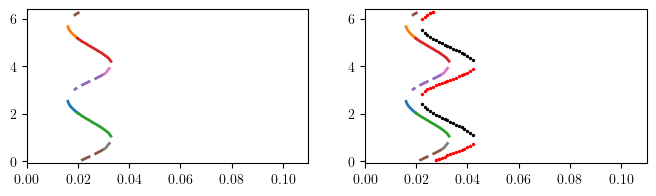

In [193]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [80]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+.0001+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.0191 2.090661658951081
phi init 2.090661658951081
Y [-1.05265277e-01  2.43060880e-01  9.86285861e-02  3.89719093e-01  2.72860924e-01 -1.96456953e+00  4.01940772e-04  6.28312233e+00]
mkdir ./data/vdp_thal11_b0=-0.112/
* Loading LC data...
self.T 6.283185307179586 omfix 0.9999899765704562
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.00035612449808745933
es_min,phi0 0.0196 2.090661658951081
phi init 2.090661658951081
Y [-1.04971952e-01  2.23651278e-01  9.85356162e-02  4.12016915e-01  3.59381443e-01 -1.95037624e+00  5.08752350e-04  6.28312125e+00]
mkdir ./data/vdp_thal11_b1=-0.112/
* Loading LC data...
self.T 6.283185307179586 omfix 0.9999898047604543
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.00038932445790013375
es_min,phi0 0.0201 2.090661658951081
phi init 2.090661658951081
Y [-5.16129773e-01  6.37671715e-01  1.04097782e-01  1.66156601e-04 -1.75253534e+

#### Monodromys max

In [81]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-.0001-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.03290000000000001 0.9683977354648476
phi init 0.9683977354648476
Y [-0.10650398  0.22263737  0.09814171  0.41253525  1.52097454 -1.27276231  0.48274211  6.28321603]
mkdir ./data/vdp_thal11_b0=-0.112/
* Loading LC data...
self.T 6.283185307179586 omfix 0.9999899765704562
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.00035612449808745933
es_min,phi0 0.03240000000000001 0.9683977354648476
phi init 0.9683977354648476
Y [-0.10652802  0.2184517   0.0981332   0.41733374  1.45391743 -1.3483252   0.44965608  6.2832053 ]
mkdir ./data/vdp_thal11_b1=-0.112/
* Loading LC data...
self.T 6.283185307179586 omfix 0.9999898047604543
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.00038932445790013375
es_min,phi0 0.03190000000000001 0.9683977354648476
phi init 0.9683977354648476
Y [-0.10629603  0.24074703  0.09823606  0.39173516  1.37495141 -1.42848201  0.40233766  6.28319669]

In [82]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-.12

#### Branches eps stable

In [83]:
b=-.12
kw_b['recompute'] = False
kw_b['b'] = b

In [84]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0.001,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [
    dict(phi0=5.1,eps_init=0.045,eps_final=0.001,deps=-.001),
    dict(phi0=1.5,eps_init=0.044,eps_final=0.15,deps=.001),
]

In [85]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 5.1
phi init 1.5


In [86]:
# # get an initial condition for a stable branch for small eps
# dat,Yinit = follow_phase_diffs(**dict(phi0=2.5,eps_init=0.039,eps_final=0.03,deps=-.01),return_point=True,**kw_b)
# # dat,Yinit = follow_phase_diffs_u(**dict(phi0=1.2,eps_init=0.019,eps_final=0.018,deps=-.01),return_point=True,**kw_b)

In [87]:
# for i in range(len(in_dicts)):
#     in1 = in_dicts[i]
#     dat = follow_phase_diffs(**in1,**kw_b)
#     data_bs_list.append(dat)

In [88]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [89]:
kw_b['recompute'] = False
kw_b['b'] = b

In [90]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.045,eps_final=0.01,deps=-1),return_point=True,**kw_b)
# dat,Yinit = follow_phase_diffs_u(**dict(phi0=1.2,eps_init=0.019,eps_final=0.018,deps=-.01),return_point=True,**kw_b)

phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.12_ei=0.045_ef=0.01_de=-1.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.12_ei=0.045_ef=0.01_de=-1.txt


In [91]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=3.5,eps_init=0.045,eps_final=0.001,deps=-.001),
            dict(phi0=3.,eps_init=0.044,eps_final=0.1,deps=.001),
            #dict(phi0=3,eps_init=0.049,eps_final=0.1,deps=.001)
           ]

In [92]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.12_ei=0.045_ef=0.001_de=-0.001.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.12_ei=0.045_ef=0.001_de=-0.001.txt
phi init 3.0
phase_diffs_u_init=3.0_nm=32_b=-0.12_ei=0.044_ef=0.1_de=0.001.txt
phase_diffs_u_pt_init=3.0_nm=32_b=-0.12_ei=0.044_ef=0.1_de=0.001.txt


In [93]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

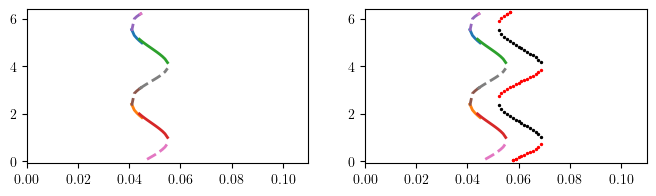

In [94]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [95]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+.0001+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.0411 2.3952706426478514
phi init 2.3952706426478514
Y [-0.1020299   0.22593509  0.09851405  0.41225113 -1.71651581  0.96981666  0.02618586  6.28304226]
mkdir ./data/vdp_thal11_b0=-0.12/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0002236613413527
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0009632101628537308
es_min,phi0 0.0416 2.3952706426478514
phi init 2.3952706426478514
Y [-0.10201621  0.22573134  0.09853127  0.41248325 -1.77192859  0.86258524  0.02315638  6.28304275]
mkdir ./data/vdp_thal11_b1=-0.12/
* Loading LC data...
self.T 6.283185307179586 omfix 0.999977311662661
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0012196300330934555
es_min,phi0 0.0421 2.3952706426478514
phi init 2.3952706426478514
Y [-0.10237607  0.24380317  0.09861444  0.39204967 -1.79919409  0.8020484   0.02163698  6.28304576]
mkdir ./data/vdp_thal11_b2=-0.12/
* Loading

#### Monodromys max

In [96]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-.0001-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.054900000000000004 0.9935660504207284
phi init 0.9935660504207284
Y [-0.10802433  0.24032678  0.0976535   0.39098204  1.50948381 -1.26220381  0.4803243   6.28329627]
mkdir ./data/vdp_thal11_b0=-0.12/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0002236613413527
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0009632101628537308
es_min,phi0 0.054400000000000004 0.9935660504207284
phi init 0.9935660504207284
Y [-0.10758114  0.22655159  0.09760711  0.40712595  1.45151002 -1.32765515  0.45145713  6.28328213]
mkdir ./data/vdp_thal11_b1=-0.12/
* Loading LC data...
self.T 6.283185307179586 omfix 0.999977311662661
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0012196300330934555
es_min,phi0 0.0539 0.9935660504207284
phi init 0.9935660504207284
Y [-0.10735959  0.22630411  0.0976181   0.40746187  1.39494115 -1.38655447  0.41851853  6.28326884]
mkdir ./data/vd

In [97]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-.13

#### Branches eps stable

In [98]:
b=-.13
kw_b['recompute'] = False
kw_b['b'] = b

In [99]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0.001,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [
    dict(phi0=4,eps_init=0.075,eps_final=0.001,deps=-.001),
    dict(phi0=4,eps_init=0.074,eps_final=0.1,deps=.001),
   ]

In [100]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 4
phi init 4


In [101]:
# # get an initial condition for a stable branch for small eps
# dat,Yinit = follow_phase_diffs(**dict(phi0=2.5,eps_init=0.039,eps_final=0.03,deps=-.01),return_point=True,**kw_b)
# # dat,Yinit = follow_phase_diffs_u(**dict(phi0=1.2,eps_init=0.019,eps_final=0.018,deps=-.01),return_point=True,**kw_b)

In [102]:
# for i in range(len(in_dicts)):
#     in1 = in_dicts[i]
#     dat = follow_phase_diffs(**in1,**kw_b)
#     data_bs_list.append(dat)

In [103]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [104]:
kw_b['recompute'] = False
kw_b['b'] = b

In [105]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.075,eps_final=0,deps=-1),return_point=True,**kw_b)
# dat,Yinit = follow_phase_diffs_u(**dict(phi0=1.2,eps_init=0.019,eps_final=0.018,deps=-.01),return_point=True,**kw_b)

phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.13_ei=0.075_ef=0_de=-1.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.13_ei=0.075_ef=0_de=-1.txt


In [106]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=3.5,eps_init=0.075,eps_final=0.001,deps=-.001),
            dict(phi0=3.5,eps_init=0.074,eps_final=0.1,deps=.001),
            #dict(phi0=3,eps_init=0.049,eps_final=0.1,deps=.001)
           ]

In [107]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.13_ei=0.075_ef=0.001_de=-0.001.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.13_ei=0.075_ef=0.001_de=-0.001.txt
phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.13_ei=0.074_ef=0.1_de=0.001.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.13_ei=0.074_ef=0.1_de=0.001.txt


In [108]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

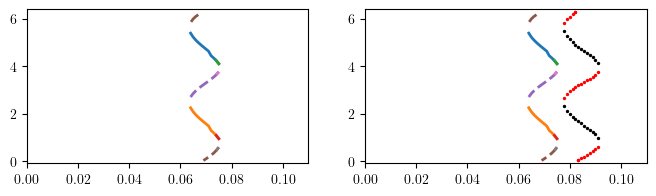

In [109]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [110]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+.0001+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.06409999999999999 2.24466620093828
phi init 2.24466620093828
Y [-0.10082039  0.22703908  0.09826703  0.41203265 -1.78883069  0.77889153  0.02104154  6.28297144]
mkdir ./data/vdp_thal11_b0=-0.13/
* Loading LC data...
self.T 6.283185307179586 omfix 0.9999659647826952
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0007410308402259126
es_min,phi0 0.06459999999999999 2.24466620093828
phi init 2.24466620093828
Y [-0.10107025  0.21985425  0.09826302  0.41993863 -1.83069633  0.67094868  0.01867321  6.2829945 ]
mkdir ./data/vdp_thal11_b1=-0.13/
* Loading LC data...
self.T 6.283185307179586 omfix 0.999969635412917
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0009330183830066201
es_min,phi0 0.06509999999999999 2.24466620093828
phi init 2.24466620093828
Y [-0.10086311  0.2338912   0.09833862  0.40432522 -1.85124116  0.60811448  0.01743782  6.28301767]
mkdir ./data/vdp

#### Monodromys max

In [111]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-.0001-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.0749 2.24466620093828
phi init 2.24466620093828
Y [-0.1090164   0.22485885  0.09706984  0.40812608  1.47898522 -1.27534785  0.46865814  6.28339994]
mkdir ./data/vdp_thal11_b0=-0.13/
* Loading LC data...
self.T 6.283185307179586 omfix 0.9999659647826952
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0007410308402259126
es_min,phi0 0.0744 2.24466620093828
phi init 2.24466620093828
Y [-0.10861474  0.23216275  0.09711198  0.39969956  1.40962682 -1.35138348  0.43035832  6.28338477]
mkdir ./data/vdp_thal11_b1=-0.13/
* Loading LC data...
self.T 6.283185307179586 omfix 0.999969635412917
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0009330183830066201
es_min,phi0 0.0739 2.24466620093828
phi init 2.24466620093828
Y [-0.10869937  0.21808639  0.09706884  0.41604254  1.36918164 -1.39156298  0.40509048  6.28336829]
mkdir ./data/vdp_thal11_b2=-0.13/
* Loading LC data...


In [112]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-.15

#### Branches eps stable

In [113]:
b=-.15
kw_b['recompute'] = False
kw_b['b'] = b

In [114]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0.001,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [
    dict(phi0=4,eps_init=0.1,eps_final=0.001,deps=-.001,max_iter=50),
    dict(phi0=4,eps_init=0.099,eps_final=0.1,deps=.001,max_iter=50),
   ]

In [115]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 4
phi init 4


In [116]:
# # get an initial condition for a stable branch for small eps
# dat,Yinit = follow_phase_diffs(**dict(phi0=2.5,eps_init=0.039,eps_final=0.03,deps=-.01),return_point=True,**kw_b)
# # dat,Yinit = follow_phase_diffs_u(**dict(phi0=1.2,eps_init=0.019,eps_final=0.018,deps=-.01),return_point=True,**kw_b)

In [117]:
# for i in range(len(in_dicts)):
#     in1 = in_dicts[i]
#     dat = follow_phase_diffs(**in1,**kw_b)
#     data_bs_list.append(dat)

In [118]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [119]:
kw_b['recompute'] = False
kw_b['b'] = b

In [120]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.1,eps_final=0,deps=-1),return_point=True,**kw_b)
# dat,Yinit = follow_phase_diffs_u(**dict(phi0=1.2,eps_init=0.019,eps_final=0.018,deps=-.01),return_point=True,**kw_b)

phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.15_ei=0.1_ef=0_de=-1.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.15_ei=0.1_ef=0_de=-1.txt


In [121]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=3.5,eps_init=0.1,eps_final=0.001,deps=-.001),
            dict(phi0=3.5,eps_init=0.099,eps_final=0.1,deps=.001),
            #dict(phi0=3,eps_init=0.049,eps_final=0.1,deps=.001)
           ]

In [122]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.15_ei=0.1_ef=0.001_de=-0.001.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.15_ei=0.1_ef=0.001_de=-0.001.txt
phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.15_ei=0.099_ef=0.1_de=0.001.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.15_ei=0.099_ef=0.1_de=0.001.txt


In [123]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

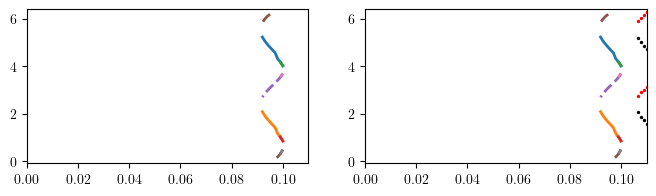

In [124]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [125]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+.0001+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.0921 2.0790613168274064
phi init 2.0790613168274064
Y [-0.09962473  0.22299613  0.09795972  0.41753225 -1.84231288  0.56190149  0.01649392  6.28300565]
mkdir ./data/vdp_thal11_b0=-0.15/
* Loading LC data...
self.T 6.283185307179586 omfix 0.9999917550924367
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.000392330306739216
es_min,phi0 0.0926 2.0790613168274064
phi init 2.0790613168274064
Y [-1.07579085e-01  2.22989587e-01  9.67236247e-02  4.09464181e-01  4.97394742e-01 -1.86223187e+00  1.18636385e-03  6.28307368e+00]
mkdir ./data/vdp_thal11_b1=-0.15/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0000210803354992
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0006256465740974751
es_min,phi0 0.0931 2.0790613168274064
phi init 2.0790613168274064
Y [-1.07918386e-01  2.16504275e-01  9.66841456e-02  4.16873972e-01  6.03446385e-01 -1.83154067e+00  2.97061206e

#### Monodromys max

In [126]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-.0001-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.0999 2.0790613168274064
phi init 2.0790613168274064
Y [-0.11075181  0.23212952  0.09644046  0.39836215  1.50761669 -1.21496524  0.4856047   6.28358981]
mkdir ./data/vdp_thal11_b0=-0.15/
* Loading LC data...
self.T 6.283185307179586 omfix 0.9999917550924367
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.000392330306739216
es_min,phi0 0.0994 2.0790613168274064
phi init 2.0790613168274064
Y [-0.11040422  0.23865457  0.0964795   0.39075658  1.42835944 -1.30710876  0.44466951  6.2835797 ]
mkdir ./data/vdp_thal11_b1=-0.15/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0000210803354992
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0006256465740974751
es_min,phi0 0.0989 2.0790613168274064
phi init 2.0790613168274064
Y [-0.10983361  0.2292014   0.09646014  0.40203745  1.37200431 -1.36528061  0.41027451  6.28356198]
mkdir ./data/vdp_thal11_b2=-0.15/
* Loading

In [127]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-.2

#### Branches eps stable

In [128]:
b=-.2
kw_b['recompute'] = False
kw_b['b'] = b

In [129]:
# eps_list = np.linspace(.08,.15,50)
# for eps0 in eps_list:
#     dat,Yinit = follow_phase_diffs(**dict(phi0=2.,eps_init=eps0,eps_final=0,deps=-1),return_point=True,**kw_b)

In [130]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0.001,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [
    dict(phi0=5.01,eps_init=0.115,eps_final=.113,deps=-.0002,max_iter=50),
    dict(phi0=5.01,eps_init=0.114,eps_final=0.12,deps=.0002,max_iter=50),
   ]

In [131]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 5.01
phi init 5.01


In [132]:
# # get an initial condition for a stable branch for small eps
# dat,Yinit = follow_phase_diffs(**dict(phi0=2.5,eps_init=0.039,eps_final=0.03,deps=-.01),return_point=True,**kw_b)
# # dat,Yinit = follow_phase_diffs_u(**dict(phi0=1.2,eps_init=0.019,eps_final=0.018,deps=-.01),return_point=True,**kw_b)

In [133]:
# for i in range(len(in_dicts)):
#     in1 = in_dicts[i]
#     dat = follow_phase_diffs(**in1,**kw_b)
#     data_bs_list.append(dat)

In [134]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [135]:
kw_b['recompute'] = False
kw_b['b'] = b

In [136]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.115,eps_final=0,deps=-1),return_point=True,**kw_b)
# dat,Yinit = follow_phase_diffs_u(**dict(phi0=1.2,eps_init=0.019,eps_final=0.018,deps=-.01),return_point=True,**kw_b)

phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.2_ei=0.115_ef=0_de=-1.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.2_ei=0.115_ef=0_de=-1.txt


In [137]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=2.5,eps_init=0.115,eps_final=0.113,deps=-.001),
            dict(phi0=2.5,eps_init=0.114,eps_final=0.12,deps=.001),
            #dict(phi0=3,eps_init=0.049,eps_final=0.1,deps=.001)
           ]

In [138]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 2.5
phase_diffs_u_init=2.5_nm=32_b=-0.2_ei=0.115_ef=0.113_de=-0.001.txt
phase_diffs_u_pt_init=2.5_nm=32_b=-0.2_ei=0.115_ef=0.113_de=-0.001.txt
phi init 2.5
phase_diffs_u_init=2.5_nm=32_b=-0.2_ei=0.114_ef=0.12_de=0.001.txt
phase_diffs_u_pt_init=2.5_nm=32_b=-0.2_ei=0.114_ef=0.12_de=0.001.txt


In [139]:
# save hyperparametersNN
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

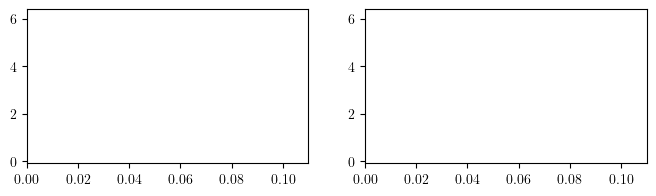

In [140]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [141]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+.0001+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.11349999999999996 2.2057352634996263
phi init 2.2057352634996263
Y [-0.09840139  0.23427744  0.09764343  0.4060894  -1.79418667  0.65720333  0.01824702  6.28292593]
mkdir ./data/vdp_thal11_b0=-0.2/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0006316211038786
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = (-0.019221365797551973+0j)
es_min,phi0 0.11399999999999996 2.2057352634996263
phi init 2.2057352634996263
Y [-1.08464900e-01  2.36141574e-01  9.62108244e-02  3.92954070e-01  4.89643367e-01 -1.84951943e+00  1.12388105e-03  6.28313593e+00]
mkdir ./data/vdp_thal11_b1=-0.2/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0008018498325497
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = (-0.02100051926631268+0j)
es_min,phi0 0.11449999999999996 2.2057352634996263
phi init 2.2057352634996263
Y [-1.08425736e-01  2.24721677e-01  9.61689555e-02  4.06333657e-01

#### Monodromys max

In [142]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-.0001-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.11870000000000014 0.6047408373567382
phi init 0.6047408373567382
Y [-2.10597054e-01  5.18366457e-01  9.79790950e-02  6.64819704e-03 -1.81622283e+00 -4.72395400e-01  5.34518128e-03  6.28371793e+00]
mkdir ./data/vdp_thal11_b0=-0.2/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0006316211038786
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = (-0.019221365797551973+0j)
es_min,phi0 0.11820000000000014 0.6047408373567382
phi init 0.6047408373567382
Y [-0.11199588  0.22218992  0.09590814  0.40922241  1.49063901 -1.21550611  0.48035736  6.28375826]
mkdir ./data/vdp_thal11_b1=-0.2/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0008018498325497
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = (-0.02100051926631268+0j)
es_min,phi0 0.11770000000000014 0.6047408373567382
phi init 0.6047408373567382
Y [-0.11117186  0.22210006  0.09593122  0.40948631  1.38660457 -1.

In [143]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-.3

#### Branches eps stable

In [144]:
b=-.3
kw_b['recompute'] = False
kw_b['b'] = b

In [145]:
# eps_list = np.linspace(.1,.12,50)
# for eps0 in eps_list:
#     dat,Yinit = follow_phase_diffs(**dict(phi0=5.,eps_init=eps0,eps_final=0,deps=-1),return_point=True,**kw_b)

In [146]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0.001,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [
    dict(phi0=5.5,eps_init=0.107,eps_final=.1,deps=-.0001,max_iter=50),
    dict(phi0=4.5,eps_init=0.1069,eps_final=0.11,deps=.0001,max_iter=50),
]

In [147]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 5.5
phi init 4.5


In [148]:
# # get an initial condition for a stable branch for small eps
# dat,Yinit = follow_phase_diffs(**dict(phi0=2.5,eps_init=0.039,eps_final=0.03,deps=-.01),return_point=True,**kw_b)
# # dat,Yinit = follow_phase_diffs_u(**dict(phi0=1.2,eps_init=0.019,eps_final=0.018,deps=-.01),return_point=True,**kw_b)

In [149]:
# for i in range(len(in_dicts)):
#     in1 = in_dicts[i]
#     dat = follow_phase_diffs(**in1,**kw_b)
#     data_bs_list.append(dat)

In [150]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [151]:
kw_b['recompute'] = False
kw_b['b'] = b

In [152]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.107,eps_final=0,deps=-1),return_point=True,**kw_b)
# dat,Yinit = follow_phase_diffs_u(**dict(phi0=1.2,eps_init=0.019,eps_final=0.018,deps=-.01),return_point=True,**kw_b)

phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.3_ei=0.107_ef=0_de=-1.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.3_ei=0.107_ef=0_de=-1.txt


In [153]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=2.5,eps_init=0.107,eps_final=0.1,deps=-.0001),
            dict(phi0=2.5,eps_init=0.1069,eps_final=0.11,deps=.0001),
            #dict(phi0=3,eps_init=0.049,eps_final=0.1,deps=.001)
           ]

In [154]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 2.5
phase_diffs_u_init=2.5_nm=32_b=-0.3_ei=0.107_ef=0.1_de=-0.0001.txt
phase_diffs_u_pt_init=2.5_nm=32_b=-0.3_ei=0.107_ef=0.1_de=-0.0001.txt
phi init 2.5
phase_diffs_u_init=2.5_nm=32_b=-0.3_ei=0.1069_ef=0.11_de=0.0001.txt
phase_diffs_u_pt_init=2.5_nm=32_b=-0.3_ei=0.1069_ef=0.11_de=0.0001.txt


In [155]:
# save hyperparametersNN
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

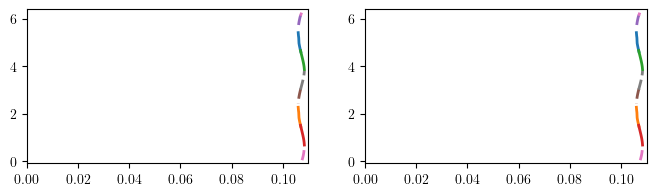

In [156]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [157]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+.0001+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.10609999999999997 2.2657389431378014
phi init 2.2657389431378014
Y [-0.09883925  0.22384499  0.09772016  0.41723802 -1.80768731  0.63577753  0.01783954  6.28294042]
mkdir ./data/vdp_thal11_b0=-0.3/
* Loading LC data...
self.T 6.283185307179586 omfix 0.9991012371111494
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.004763318711003957
es_min,phi0 0.10659999999999997 2.2657389431378014
phi init 2.2657389431378014
Y [-0.10820236  0.23441781  0.09641197  0.39532259  0.68772722 -1.79361101  0.00661536  6.28326578]
mkdir ./data/vdp_thal11_b1=-0.3/
* Loading LC data...
self.T 6.283185307179586 omfix 0.9998501494715458
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.009967466967733042
es_min,phi0 0.10709999999999997 2.2657389431378014
phi init 2.2657389431378014
Y [-0.10833497  0.22880057  0.09634456  0.40195585  0.97020035 -1.6621537   0.08267607  6.2834556 ]
mkdir .

#### Monodromys max

In [158]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-.0001-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.10830000000000004 0.676955320669764
phi init 0.676955320669764
Y [-0.11174312  0.23987977  0.09624778  0.38858602  1.54398271 -1.15981812  0.50234206  6.28365729]
mkdir ./data/vdp_thal11_b0=-0.3/
* Loading LC data...
self.T 6.283185307179586 omfix 0.9991012371111494
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.004763318711003957
es_min,phi0 0.10780000000000003 0.676955320669764
phi init 0.676955320669764
Y [-0.10995809  0.23756279  0.09627095  0.39174192  1.29069599 -1.43358365  0.35247202  6.28362276]
mkdir ./data/vdp_thal11_b1=-0.3/
* Loading LC data...
self.T 6.283185307179586 omfix 0.9998501494715458
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.009967466967733042
es_min,phi0 0.10730000000000003 0.676955320669764
phi init 0.676955320669764
Y [-0.10878595  0.22039359  0.09627872  0.41180942  1.07879777 -1.59523085  0.16524398  6.28351314]
mkdir ./data/

In [159]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

# Two parameter full

In [160]:
twopar_neg = np.loadtxt('../v2_bifdat_2par/redu/vdp_thal_32_o2_neg_fixed.dat')
twopar_neg2 = np.loadtxt('../v2_bifdat_2par/redu/vdp_thal_32_o2_neg2_fixed.dat')

(-0.31, -0.09)

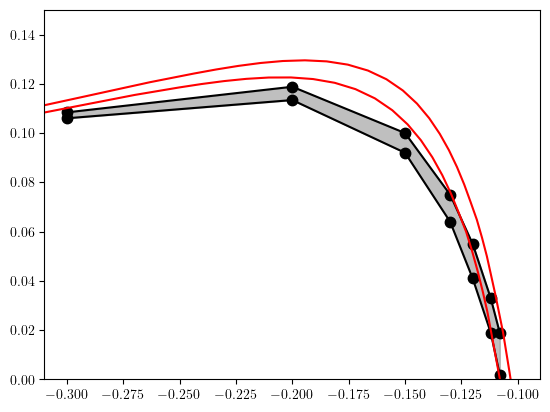

In [161]:
fig,axs = plt.subplots()
axs.fill_between(b_vals_full,e_vals_full,e_hi_full,color='gray',alpha=.5)
axs.plot(b_vals_full,e_vals_full,marker='.',color='k',markersize=15)
axs.plot(b_vals_full,e_hi_full,marker='.',color='k',markersize=15)

axs.plot(twopar_neg[:,1],twopar_neg[:,0],color='r')
axs.plot(twopar_neg2[:,1],twopar_neg2[:,0],color='r')

axs.set_ylim(0,.15)
axs.set_xlim(-.31,-.09)

In [162]:
fname_lo = '../v2_bifdat_2par/full/vdp_thal_2par_lo_{}{}.dat'.format(a._n[1],a._m[1])
fname_hi = '../v2_bifdat_2par/full/vdp_thal_2par_hi_{}{}.dat'.format(a._n[1],a._m[1])

arr_lo = np.zeros([len(b_vals_full),2])
arr_hi = np.zeros([len(b_vals_full),2])

arr_lo[:,0] = b_vals_full
arr_lo[:,1] = e_vals_full

arr_hi[:,0] = b_vals_full
arr_hi[:,1] = e_hi_full

np.savetxt(fname_lo,arr_lo)
np.savetxt(fname_hi,arr_hi)

# Eigenvalue Convergence Plot

## Min

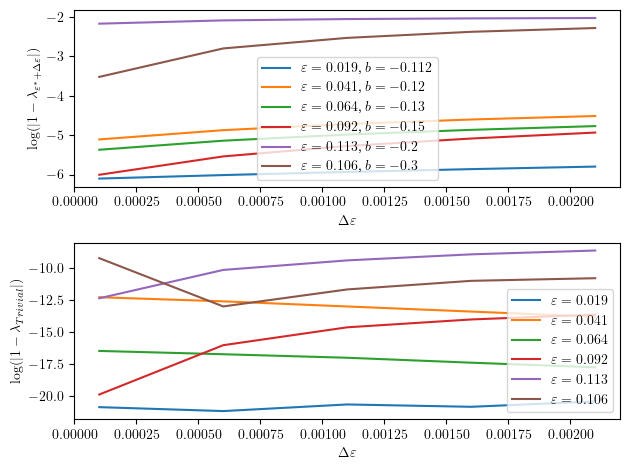

In [163]:
fig,axs = plt.subplots(2,1)

#es_min+.0001+0.0005*i
#ee = es_max-.0001-0.0005*i
eps_values = np.arange(0.0001,0.0001+0.0005*5,.0005)
skipn = 1

for j in range(len(eigenvalues_min_all[::skipn])):
    nn = len(eigenvalues_min_all[::skipn][j])

    at_eigen = []
    near_eigen = []
    
    for i in range(nn):
        eigenval = np.array(eigenvalues_min_all[::skipn][j][i])
        
        min1 = np.argsort(np.abs(eigenval-1))[:2]
        periodic1,bif1 = eigenval[min1]
        
        at_eigen.append(periodic1)
        near_eigen.append(bif1)

    
    ee = e_vals_mono_min[::skipn][j]
    e0 = ee[0]
    de = ee - e0
    
    axs[0].plot(eps_values,np.log(np.abs(1-np.array(near_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$, ' +r'$b='+str(b_min_all[j])+r'$')
    axs[1].plot(eps_values,np.log(np.abs(1-np.array(at_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$')
    #axs[1].plot(lc_list2,label='Near Bifurcation')

    axs[0].legend()
    axs[1].legend()

    axs[0].set_xlabel(r'$\Delta\varepsilon$')
    axs[1].set_xlabel(r'$\Delta\varepsilon$')
    #axs[1].set_xlabel('Point')
    
    axs[0].set_ylabel(r'$\log(|1 - \lambda_{\varepsilon^*+\Delta\varepsilon}|)$')
    axs[1].set_ylabel(r'$\log(|1-\lambda_{Trivial}|)$')

    plt.tight_layout()
    plt.savefig('../figs/supp_convergence_vdp_thal_min_{}{}.png'.format(a._n[1],a._m[1]))

## Max

j,nn 0 5
0 [ 9.98469456e-01  1.00000000e+00  6.28176848e-01  6.10058196e-01  3.33578923e-04  4.66614869e-17 -9.28272186e-18]
1 [ 9.98153338e-01  1.00000000e+00  6.28161356e-01  6.09920706e-01  3.33593556e-04  4.62600048e-17 -7.93048475e-17]
2 [ 9.97945829e-01  1.00000000e+00  6.28149659e-01  6.09783990e-01  3.33600523e-04 -7.89983177e-18  4.63235249e-17]
3 [9.97806768e-01 1.00000000e+00 6.28140924e-01 6.09647720e-01 3.33601482e-04 4.81429395e-17 4.33605215e-17]
4 [ 9.97716216e-01  1.00000000e+00  6.28134759e-01  6.09511734e-01  3.33597576e-04  4.62269759e-17 -2.74010910e-17]
[0.9984694562147193, 0.9981533383641902, 0.997945828795207, 0.9978067679643889, 0.997716215759497]
j,nn 1 5
0 [3.32749383e-04 9.97764905e-01 9.99999999e-01 6.10134501e-01 6.28206388e-01 2.00595349e-17 4.69296315e-17]
1 [3.32704734e-04 9.97556792e-01 9.99999999e-01 6.28195117e-01 6.10265320e-01 5.82750101e-17 4.63687318e-17]
2 [3.32664562e-04 9.97354983e-01 9.99999999e-01 6.28182895e-01 6.10396308e-01 6.29386914e-17

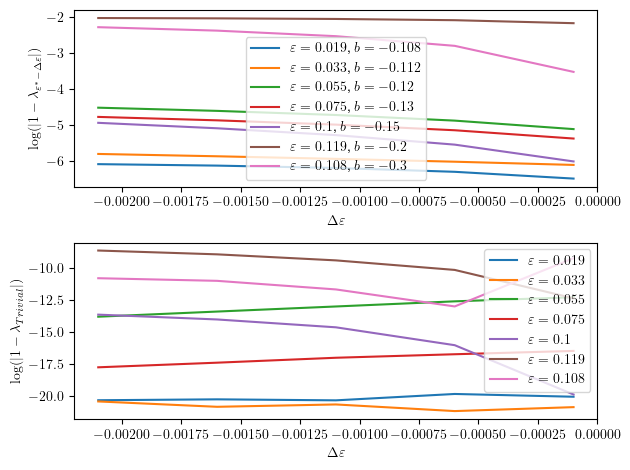

In [164]:
fig,axs = plt.subplots(2,1)

#es_min+.0001+0.0005*i
#ee = es_max-.0001-0.0005*i
eps_values = np.arange(-0.0001,0.0001-0.0005*5,-.0005)
skipn = 1


for j in range(len(eigenvalues_max_all[::skipn])):
    nn = len(eigenvalues_max_all[::skipn][j])
    print('j,nn',j,nn)

    at_eigen = []
    near_eigen = []
    
    for i in range(nn):
        eigenval = np.array(eigenvalues_max_all[::skipn][j][i])
        print(i,eigenval)
        
        max1 = np.argsort(np.abs(eigenval-1))[:2]
        periodic1,bif1 = eigenval[max1]
        
        at_eigen.append(periodic1)
        near_eigen.append(bif1)

    print(near_eigen)

    ee = e_vals_mono_max[::skipn][j]
    e0 = ee[0]
    de = ee - e0
    
    axs[0].plot(eps_values,np.log(np.abs(1-np.array(near_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$, ' +r'$b='+str(b_max_all[j])+r'$')
    axs[1].plot(eps_values,np.log(np.abs(1-np.array(at_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$')
    #axs[1].plot(lc_list2,label='Near Bifurcation')

    axs[0].legend()
    axs[1].legend()

    axs[0].set_xlabel(r'$\Delta\varepsilon$')
    axs[1].set_xlabel(r'$\Delta\varepsilon$')
    #axs[1].set_xlabel('Point')
    
    axs[0].set_ylabel(r'$\log(|1 - \lambda_{\varepsilon^*-\Delta\varepsilon}|)$')
    axs[1].set_ylabel(r'$\log(|1-\lambda_{Trivial}|)$')

    plt.tight_layout()
    plt.savefig('../figs/supp_convergence_vdp_thal_max_{}{}.png'.format(a._n[1],a._m[1]))